<a href="https://colab.research.google.com/github/Dana1402/course-work-cnn/blob/main/BaselineModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import

In [ ]:
import tensorflow.keras
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
import shutil
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image

# import cv2
# from skimage import data, io, filters
# from skimage.color import rgb2gray
# from skimage.io import imread, imsave
# from skimage.filters import threshold_otsu
# from skimage import img_as_uint

import warnings
warnings.simplefilter('ignore')

In [ ]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Чистим папку, если чт-то пошло не так
shutil.rmtree('/content/drive/MyDrive/course_work_nn/train')

### Preparing data

In [ ]:
!cd /content/drive/MyDrive/course_work_nn && unzip -q train.zip

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/com_vision/train.csv')

In [ ]:
df.head()

,Unnamed: 0,image_path,emotion
0,0,./train/anger/0.jpg,anger
1,1,./train/anger/1.jpg,anger
2,2,./train/anger/10.jpg,anger
3,3,./train/anger/100.jpg,anger
4,4,./train/anger/1000.jpg,anger


### Unbalanced classes

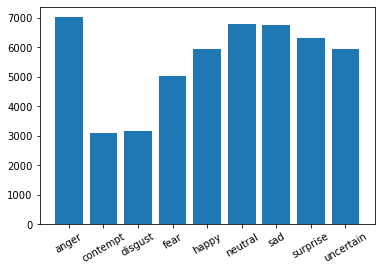

In [ ]:
df2 = df[['Unnamed: 0','emotion']].groupby('emotion').agg('count')
plt.bar(df2.index, df2['Unnamed: 0'])
plt.xticks(rotation=30)
plt.show()

In [ ]:
# преобразуем имена файлов(убрать все кроме имени)
for i in range(len(df)):  
    df['image_path'][i] = df['image_path'][i].replace("./train/", "")

Веса для классов

In [ ]:
class_weight = {}
for i, j  in enumerate(set(df.emotion)):
    count_of_samples = df[df['emotion'] == j].agg('count')[0]
    total = df.shape[0]
    weight = (1 / count_of_samples) * (total / 9.0)

    class_weight[i] = weight

In [ ]:
class_weight

{0: 1.1024319323288396,
 1: 0.8183468236448369,
 2: 0.933781136300028,
 3: 1.8024851431658562,
 4: 0.938192452617963,
 5: 0.7918921484857117,
 6: 0.825024727992087,
 7: 1.7624933967247756,
 8: 0.8794348674152566}

Разбиваем на тренировочные и валидационные данные, стратифицируем по классам.

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(df.iloc[:,0:2], df['emotion'], test_size=0.2, stratify=df['emotion'])

In [ ]:
train = pd.concat([train_x, train_y], axis = 1).reset_index(drop=True)
test = pd.concat([test_x, test_y], axis = 1).reset_index(drop=True)

Делаем one-hot encoding

In [ ]:
# Делаем one-hot encoding
ohe = OneHotEncoder(sparse = False)
new_one_features = ohe.fit_transform(train.emotion.values.reshape(-1,1))
tmp = pd.DataFrame(new_one_features, columns = ['emotion=' + str(i) for i in range(new_one_features.shape[1])])
df3_train = pd.concat([train, tmp], axis = 1)

In [ ]:
# Делаем one-hot encoding
ohe = OneHotEncoder(sparse = False)
new_one_features = ohe.fit_transform(test.emotion.values.reshape(-1,1))
tmp = pd.DataFrame(new_one_features, columns = ['emotion=' + str(i) for i in range(new_one_features.shape[1])])
df3_test = pd.concat([test, tmp], axis = 1)

In [ ]:
emotions = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise' , 'uncertain']

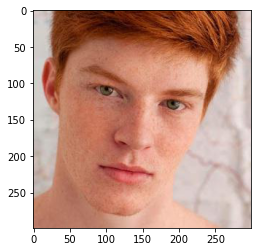

In [ ]:
from tensorflow.keras.preprocessing import image
# img = image.load_img('/content/drive/MyDrive/course_work_nn/train/anger/1000.jpg')
img = image.load_img('C:/Users/Admin/Documents/курсовая_нейронка_эмоции/train/train/anger/1000.jpg')
plt.imshow(img)

### FCN Model

#### Preparing Data

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator_1 = datagen.flow_from_dataframe(df3_train,
                                                directory='train/train/',
                                                target_size=(128,128),
                                                x_col="image_path",
                                                y_col="emotion",
                                                class_mode='categorical',
                                                color_mode = 'grayscale',
                                                shuffle=True,                                             
                                                batch_size=128)

test_generator_1 = datagen.flow_from_dataframe(df3_test,
                                                directory='train/train/',
                                                target_size=(128,128),
                                                x_col="image_path",
                                                y_col="emotion",
                                                class_mode='categorical',
                                                color_mode = 'grayscale',
                                                shuffle=True, 
                                                batch_size=128)

Found 0 validated image filenames belonging to 0 classes.
Found 0 validated image filenames belonging to 0 classes.


In [ ]:
sample = next(train_generator_1)
sample[0][0].shape
sample[0][0].reshape(-1, sample[0][0].shape[0]*sample[0][0].shape[1]).shape

(1, 16384)

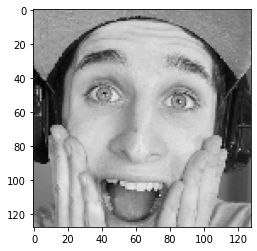

In [ ]:
plt.imshow(sample[0][1], cmap = 'gray')

In [ ]:
model = tf.keras.Sequential()

# model.add(tf.keras.layers.Input(shape = (None, 224, 224, 1)))
model.add(tf.keras.layers.Reshape((128*128, ), input_shape=(128,128,1)))
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.Dense(512, activation="relu"))
model.add(tf.keras.layers.Dense(1024, activation="relu"))
model.add(Dense(9, activation="softmax"))

model.compile(optimizer= tf.keras.optimizers.Adam(lr=1e-4),
              loss = 'categorical_crossentropy',
              metrics = ['categorical_accuracy'])


In [ ]:
# tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 16384)             0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               2097280   
_________________________________________________________________
dense_27 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_28 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_29 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_30 (Dense)             (None, 9)                 9225      
Total params: 2,796,425
Trainable params: 2,796,425
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
               filepath = 'fc_model.h5', 
               monitor = 'val_categorical_accuracy', 
               save_best_only = True,)

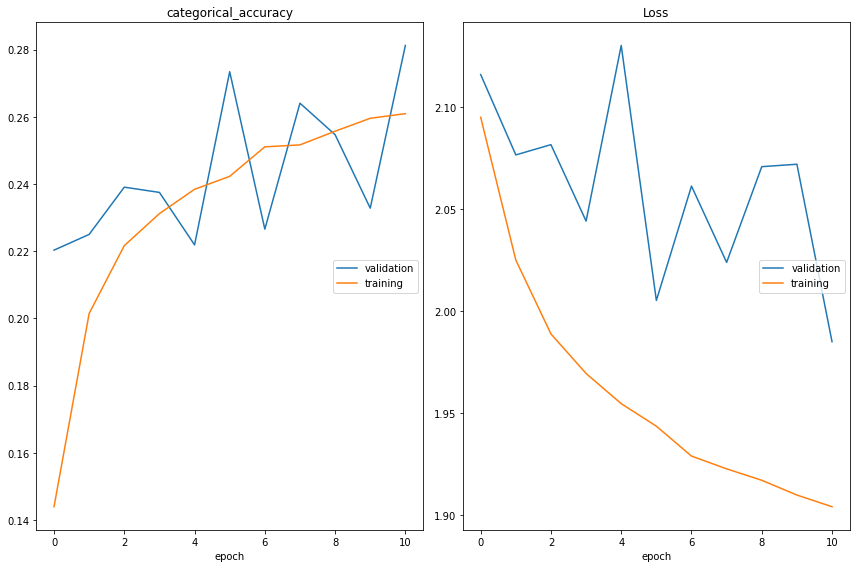

categorical_accuracy
	validation       	 (min:    0.220, max:    0.281, cur:    0.281)
	training         	 (min:    0.144, max:    0.261, cur:    0.261)
Loss
	validation       	 (min:    1.985, max:    2.130, cur:    1.985)
	training         	 (min:    1.904, max:    2.095, cur:    1.904)
1252/1252 [==============================] - 236s 189ms/step - loss: 1.9044 - categorical_accuracy: 0.2608 - val_loss: 1.9849 - val_categorical_accuracy: 0.2812
Epoch 12/40
 109/1252 [=>............................] - ETA: 3:36 - loss: 1.8846 - categorical_accuracy: 0.2672 ETA: 3:36 - loss: 1.8822 - categorical_accura

KeyboardInterrupt: 

In [ ]:
%%time
history = model.fit( train_generator_1,
#                       steps_per_epoch=20,
                      epochs = 40,
                       validation_data = test_generator_1,
                      validation_steps = 20,
                      callbacks = [PlotLossesCallback(), 
                                   model_checkpoint_callback],
                      class_weight=class_weight)

### CNN

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15076076836477711172
 xla_global_id: -1]

In [ ]:
model = models.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (128,128,1)))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(256, (3,3), activation = 'relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation = 'relu'))
model.add(tf.keras.layers.Dense(9, activation = 'softmax'))


Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 14, 14, 128)     

In [ ]:
model.compile(optimizer= tf.keras.optimizers.Adam(lr=1e-3),
              loss = 'categorical_crossentropy',
              metrics = ['categorical_accuracy'])

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
               filepath = 'CNN1_.h5', 
               monitor = 'val_categorical_accuracy', 
               save_best_only = True,)

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_categorical_accuracy",
                min_delta=0.01,
                patience=5,
                verbose=1,
                mode="max",
                baseline=None,
                restore_best_weights=False,
                start_from_epoch=0,
)

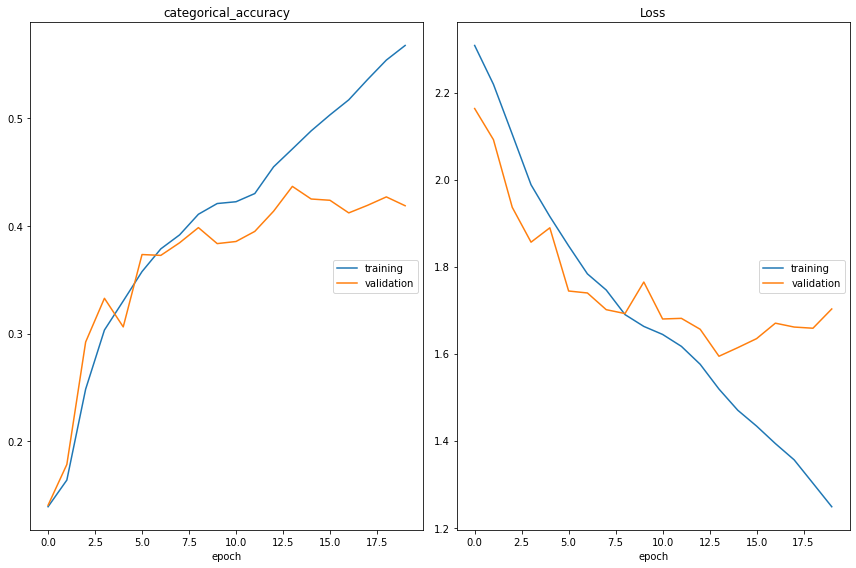

categorical_accuracy
	training         	 (min:    0.139, max:    0.568, cur:    0.568)
	validation       	 (min:    0.141, max:    0.437, cur:    0.419)
Loss
	training         	 (min:    1.248, max:    2.309, cur:    1.248)
	validation       	 (min:    1.594, max:    2.164, cur:    1.703)
80/80 [==============================] - 283s 3s/step - loss: 1.2482 - categorical_accuracy: 0.5676 - val_loss: 1.7028 - val_categorical_accuracy: 0.4187


KeyboardInterrupt: 

In [ ]:
%%time
history = model.fit( train_generator_1,
                      steps_per_epoch=600,
                      epochs = 30,
                      validation_data = test_generator_1,
                      validation_steps = 20,
                      callbacks = [PlotLossesCallback(), 
                                   model_checkpoint_callback,
                                   early_stopping_callback],
                      class_weight=class_weight,
                      workers = 8)

In [ ]:
STEP_SIZE_TEST=test_generator_1.n//test_generator_1.batch_size
pred=model.predict(test_generator_1,steps=STEP_SIZE_TEST,verbose=1)

predictions = []
for i in pred:
#     print(i)
#     print(np.argmax(i))
#     print(emotions[np.argmax(i)])
    predictions.append(emotions[np.argmax(i)])

targets = []
for i in range(len(pred)):
    sample = next(train_generator_1)
    emotion = emotions[sample[1][1].argmax()]
    targets.append(emotion)

# categories = emotions
print('Строки - реальные метки, столбцы - предсказание')
# pd.DataFrame(tf.math.confusion_matrix(targets, predictions).numpy(), index=emotions, columns=emotions)
conf_matrix = confusion_matrix(y_true=targets, y_pred=predictions)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

78/78 [==============================] - 107s 1s/step


KeyboardInterrupt: 

### Trying to use regularization on the last layer

In [ ]:
model01 = models.Sequential()

model01.add(tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (128,128,1)))
model01.add(tf.keras.layers.MaxPooling2D(2,2))
model01.add(tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'))
model01.add(tf.keras.layers.MaxPooling2D(2,2))
model01.add(tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'))
model01.add(tf.keras.layers.MaxPooling2D(2,2))
model01.add(tf.keras.layers.Conv2D(256, (3,3), activation = 'relu'))
model01.add(tf.keras.layers.Flatten())
model01.add(tf.keras.layers.Dense(256, 
#                                 kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3),
#                                 bias_regularizer=regularizers.L2(1e-4),
#                                 activity_regularizer=regularizers.L2(1e-4), 
                                activation = 'relu'))
model01.add(tf.keras.layers.Dropout(0.2))
model01.add(tf.keras.layers.Dense(9, activation = 'softmax'))

In [ ]:
model01.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['categorical_accuracy'])

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                filepath = 'CNN_reg.h5', 
                monitor = 'val_categorical_accuracy', 
                save_best_only = True,)

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_categorical_accuracy",
                min_delta=0.01,
                patience=5,
                verbose=1,
                mode="max",
                baseline=None,
                restore_best_weights=False,
                start_from_epoch=0,
)

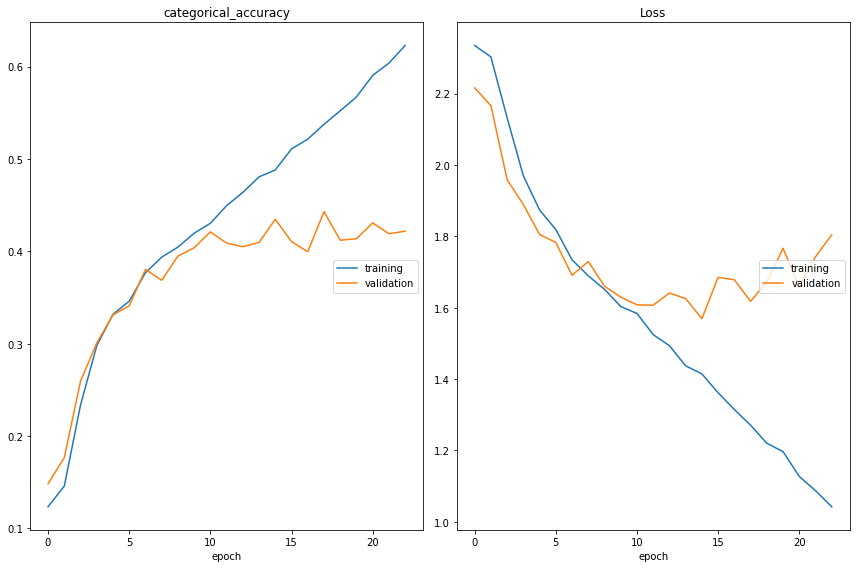

categorical_accuracy
	training         	 (min:    0.124, max:    0.623, cur:    0.623)
	validation       	 (min:    0.148, max:    0.443, cur:    0.422)
Loss
	training         	 (min:    1.042, max:    2.335, cur:    1.042)
	validation       	 (min:    1.569, max:    2.216, cur:    1.804)
100/100 [==============================] - 281s 3s/step - loss: 1.0424 - categorical_accuracy: 0.6230 - val_loss: 1.8042 - val_categorical_accuracy: 0.4219
Epoch 24/30
 15/100 [===>..........................] - ETA: 3:49 - loss: 0.9476 - categorical_accuracy: 0.6641

KeyboardInterrupt: 

In [ ]:
%%time
history = model01.fit( train_generator_1,
                      steps_per_epoch=600,
                      epochs = 30,
                      validation_data = test_generator_1,
                      validation_steps = 20,
                      callbacks = [PlotLossesCallback(), 
                                   model_checkpoint_callback, 
                                   early_stopping_callback],
                      class_weight=class_weight, 
                      workers = 8)

### Preprocessing images

Мы будем использовать предварительно обученную модель каскада Хаара для обнаружения лиц на изображении. Каскад Хаара — это метод обнаружения объектов, используемый для обнаружения объектов на изображении.

In [ ]:
face_cascade = cv2.CascadeClassifier('C:/Users/Admin/Documents/NN/haarcascade_frontalface_default.xml')

def get_bbox_faces(image):
    image = np.array(image, dtype='uint8')
    faces = face_cascade.detectMultiScale(image, 1.05, 5, 0)
    for (x, y, w, h) in faces:
#         cv2.rectangle(image, (x, y), (x+w, y+h), 
#                       (0, 0, 255), 2)

        faces = image[y:y + h, x:x + w]
        resized_image = cv2.resize(faces, (128,128)) 
        resized_image = resized_image.astype(np.float32)
        resized_image /= 255.
        contrast_image = tf.image.adjust_contrast(resized_image, 3.0)
        bright_image = tf.image.adjust_brightness(contrast_image, 0.15)   
        bboxed_img = tf.clip_by_value(bright_image, clip_value_min=0.0, clip_value_max=1.0)

        return bboxed_img
    # cv2.imshow('img', image)
    # cv2.waitKey()

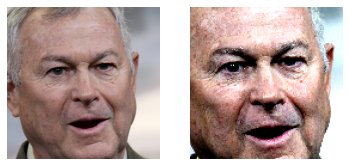

In [ ]:
img = io.imread('C:/Users/Admin/Documents/курсовая_нейронка_эмоции/train/train/anger/6.jpg')
img_th = get_bbox_faces(img)
f, ax = plt.subplots(ncols = 2)
ax[0].imshow(img)
ax[1].imshow(img_th)
ax[0].set_axis_off()
ax[1].set_axis_off()
plt.show()

In [ ]:
def get_bbox_faces(image):
    face_cascade = cv2.CascadeClassifier('C:/Users/Admin/Documents/NN/haarcascade_frontalface_default.xml')
    image = np.array(image, dtype='uint8')
    # Contrast normalization   
    image = cv2.normalize(image, None, alpha=0,beta=200, norm_type=cv2.NORM_MINMAX)
    # Denoising
    image = cv2.fastNlMeansDenoisingColored(image,None,10,10,7,21) 
    # Histograms Equalization
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.equalizeHist(image)   
    
#     R, G, B = cv2.split(image)

#     output1_R = cv2.equalizeHist(R)
#     output1_G = cv2.equalizeHist(G)
#     output1_B = cv2.equalizeHist(B)

#     image = cv2.merge((output1_R, output1_G, output1_B))

    faces = face_cascade.detectMultiScale(image, 1.1, 4)
    for (x, y, w, h) in faces:
#         cv2.rectangle(image, (x, y), (x+w+10, y+h+10), 
#                       (0, 0, 255), 2)

        faces = image[y:y + h + 50, x:x + w + 50]
        resized_image = cv2.resize(faces, (128,128)) 
        resized_image = np.expand_dims(resized_image, axis=2)
        resized_image = resized_image.astype(np.float32)
        resized_image /= 255.
        bboxed_img = tf.clip_by_value(resized_image, clip_value_min=0.0, clip_value_max=1.0)
    
    return bboxed_img 

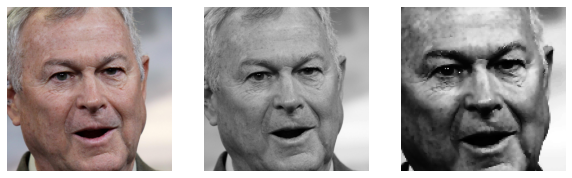

In [ ]:
img = io.imread('C:/Users/Admin/Documents/курсовая_нейронка_эмоции/train/train/anger/6.jpg')
img_th = get_bbox_faces(img)
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
f, ax = plt.subplots(figsize = (10,5), ncols = 3)
ax[0].imshow(img)
ax[1].imshow(img_gray, cmap='gray')
ax[2].imshow(img_th, cmap='gray')
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
plt.show()

In [ ]:
datagen = ImageDataGenerator(
#     rescale=1./255, 
    preprocessing_function = get_bbox_faces)

In [ ]:
train_generator_1 = datagen.flow_from_dataframe(df3_train,
                                                directory='train/train/',
                                                target_size=(224,224),
                                                x_col="image_path",
                                                y_col="emotion",
                                                class_mode='categorical',
#                                                 color_mode = 'grayscale',
#                                                 color_mode='rgb',
                                                shuffle=True,                                             
                                                batch_size=64)

test_generator_1 = datagen.flow_from_dataframe(df3_test,
                                                directory='train/train/',
                                                target_size=(224,224),
                                                x_col="image_path",
                                                y_col="emotion",
                                                class_mode='categorical',
#                                                 color_mode = 'grayscale',
#                                                 color_mode='rgb',
                                                shuffle=True, 
                                                batch_size=64)

Found 40036 validated image filenames belonging to 9 classes.
Found 10010 validated image filenames belonging to 9 classes.


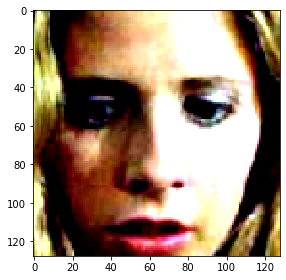

In [ ]:
sample = next(train_generator_1)
io.imshow(sample[0][1])

In [ ]:
model = models.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (224,224,3)))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(256, (3,3), activation = 'relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation = 'relu'))
model.add(tf.keras.layers.Dense(9, activation = 'softmax'))

In [ ]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['categorical_accuracy'])

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
               filepath = 'CNN_preprocess_bbox.h5', 
               monitor = 'val_categorical_accuracy', 
               save_best_only = True,)

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_categorical_accuracy",
                min_delta=0.01,
                patience=5,
                verbose=1,
                mode="max",
                baseline=None,
                restore_best_weights=False,
                start_from_epoch=0,
)

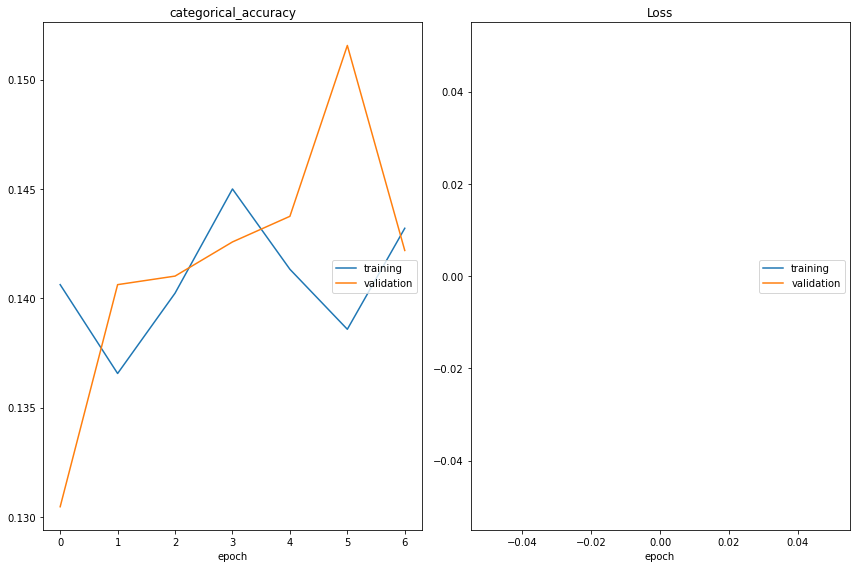

categorical_accuracy
	training         	 (min:    0.137, max:    0.145, cur:    0.143)
	validation       	 (min:    0.130, max:    0.152, cur:    0.142)
Loss
	training         	 (min:      nan, max:      nan, cur:      nan)
	validation       	 (min:      nan, max:      nan, cur:      nan)
100/100 [==============================] - 471s 5s/step - loss: nan - categorical_accuracy: 0.1432 - val_loss: nan - val_categorical_accuracy: 0.1422
Epoch 8/30
 64/100 [==================>...........] - ETA: 2:26 - loss: nan - categorical_accuracy: 0.1414

KeyboardInterrupt: 

In [ ]:
%%time
history = model.fit( train_generator_1,
                      steps_per_epoch=600,
                      epochs = 50,
                      validation_data = test_generator_1,
                      validation_steps = 20,
                      callbacks = [PlotLossesCallback(), 
                                   model_checkpoint_callback,
                                   early_stopping_callback],
                      class_weight=class_weight)

#### Contrast/brightness

In [ ]:
def improve_contrast(image):
    """increase contrast and brightness"""
    contrast_image = tf.image.adjust_contrast(image, 3.0)
    bright_image = tf.image.adjust_brightness(contrast_image, 0.15)
    image = tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=255.0)
    return image

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255, 
    preprocessing_function = improve_contrast)

In [ ]:
train_generator_1 = datagen.flow_from_dataframe(df3_train,
                                                directory='train/train/',
                                                target_size=(224,224),
                                                x_col="image_path",
                                                y_col="emotion",
                                                class_mode='categorical',
                                                color_mode = 'grayscale',
#                                                 color_mode='rgb',
                                                shuffle=True,                                             
                                                batch_size=64)

test_generator_1 = datagen.flow_from_dataframe(df3_test,
                                                directory='train/train/',
                                                target_size=(224,224),
                                                x_col="image_path",
                                                y_col="emotion",
                                                class_mode='categorical',
                                                color_mode = 'grayscale',
#                                                 color_mode='rgb',
                                                shuffle=True, 
                                                batch_size=64)

Found 40036 validated image filenames belonging to 9 classes.
Found 10010 validated image filenames belonging to 9 classes.


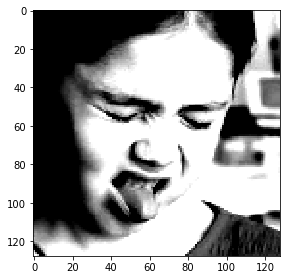

In [ ]:
sample = next(train_generator_1)
io.imshow(sample[0][0])

In [ ]:
model = models.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (224,224,1)))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(256, (3,3), activation = 'relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation = 'relu'))
model.add(tf.keras.layers.Dense(9, activation = 'softmax'))


In [ ]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['categorical_accuracy'])

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
               filepath = 'CNN_preprocess_contrast.h5', 
               monitor = 'val_categorical_accuracy', 
               save_best_only = True,)

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_categorical_accuracy",
                min_delta=0.01,
                patience=5,
                verbose=1,
                mode="max",
                baseline=None,
                restore_best_weights=False,
                start_from_epoch=0,
)

In [ ]:
%%time
history = model.fit( train_generator_1,
                      steps_per_epoch=600,
                      epochs = 100,
                      validation_data = test_generator_1,
                      validation_steps = 20,
                      callbacks = [PlotLossesCallback(), 
                                   model_checkpoint_callback,
                                   early_stopping_callback],
                      class_weight=class_weight)

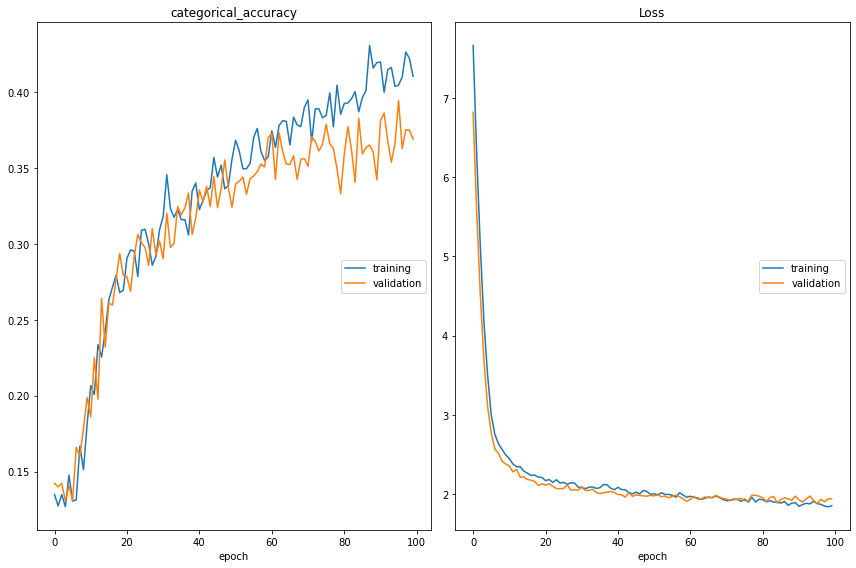

categorical_accuracy
	training         	 (min:    0.127, max:    0.431, cur:    0.411)
	validation       	 (min:    0.130, max:    0.395, cur:    0.369)
Loss
	training         	 (min:    1.842, max:    7.661, cur:    1.854)
	validation       	 (min:    1.881, max:    6.818, cur:    1.943)
20/20 [==============================] - 96s 5s/step - loss: 1.8544 - categorical_accuracy: 0.4105 - val_loss: 1.9429 - val_categorical_accuracy: 0.3691
Wall time: 2h 34min 3s


In [ ]:
%%time
history = model.fit( train_generator_1,
                      steps_per_epoch=600,
                      epochs = 100,
                      validation_data = test_generator_1,
                      validation_steps = 20,
                      callbacks = [PlotLossesCallback(), 
                                   model_checkpoint_callback,
                                   early_stopping_callback],
                      class_weight=class_weight)

#### Threshold

In [ ]:
from skimage.filters import threshold_otsu
from skimage import color
from skimage import io

In [ ]:
def preprocessing_threshold(image):
#     image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    globalthreshold = threshold_otsu(image)
    bw_image = image > globalthreshold
    bw_image = bw_image.astype('float32')
    return bw_image

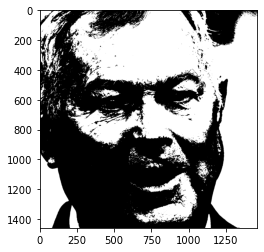

In [ ]:
img = io.imread('C:/Users/Admin/Documents/курсовая_нейронка_эмоции/train/train/anger/6.jpg')
img_th = preprocessing_threshold(img)
plt.imshow(img_th, cmap='gray')

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255, 
    preprocessing_function = preprocessing_threshold)

In [ ]:
train_generator_1 = datagen.flow_from_dataframe(df3_train,
                                                directory='train/train/',
                                                target_size=(224,224),
                                                x_col="image_path",
                                                y_col="emotion",
                                                class_mode='categorical',
                                                color_mode = 'grayscale',
#                                                 color_mode='rgb',
                                                shuffle=True,                                             
                                                batch_size=64)

test_generator_1 = datagen.flow_from_dataframe(df3_test,
                                                directory='train/train/',
                                                target_size=(224,224),
                                                x_col="image_path",
                                                y_col="emotion",
                                                class_mode='categorical',
                                               color_mode = 'grayscale',
#                                                 color_mode='rgb',
                                                shuffle=True, 
                                                batch_size=64)

Found 40036 validated image filenames belonging to 9 classes.
Found 10010 validated image filenames belonging to 9 classes.


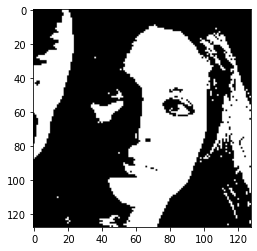

In [ ]:
sample = next(train_generator_1)
plt.imshow(sample[0][10], cmap='gray')

In [ ]:
model = models.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (224,224,1)))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(256, (3,3), activation = 'relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation = 'relu'))
model.add(tf.keras.layers.Dense(9, activation = 'softmax'))


In [ ]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['categorical_accuracy'])

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
               filepath = 'CNN_preprocess_threshold.h5', 
               monitor = 'val_categorical_accuracy', 
               save_best_only = True,)

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_categorical_accuracy",
                min_delta=0.01,
                patience=5,
                verbose=1,
                mode="max",
                baseline=None,
                restore_best_weights=False,
                start_from_epoch=0,
)

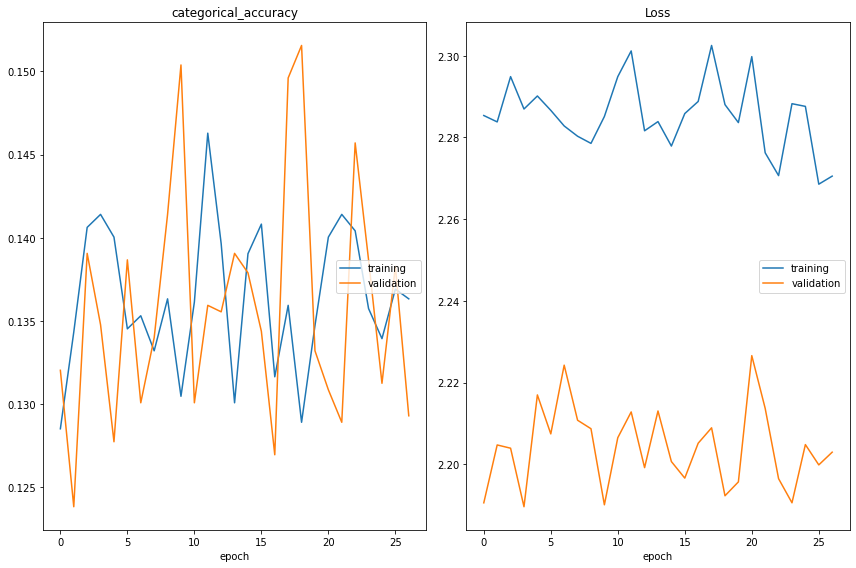

categorical_accuracy
	training         	 (min:    0.129, max:    0.146, cur:    0.136)
	validation       	 (min:    0.124, max:    0.152, cur:    0.129)
Loss
	training         	 (min:    2.269, max:    2.303, cur:    2.271)
	validation       	 (min:    2.190, max:    2.227, cur:    2.203)
40/40 [==============================] - 148s 4s/step - loss: 2.2705 - categorical_accuracy: 0.1363 - val_loss: 2.2030 - val_categorical_accuracy: 0.1293
Epoch 28/50
 6/40 [===>..........................] - ETA: 1:41 - loss: 2.2656 - categorical_accuracy: 0.1289

KeyboardInterrupt: 

In [ ]:
%%time
history = model.fit( train_generator_1,
                      steps_per_epoch=600,
                      epochs = 100,
                      validation_data = test_generator_1,
                      validation_steps = 20,
                      callbacks = [PlotLossesCallback(), 
                                   model_checkpoint_callback,
                                   early_stopping_callback],
                      class_weight=class_weight)

#### Edges

In [ ]:
def preprocessing_edges(image):
#     image = (np.array(img).astype(float))/255
    edges = filters.sobel(image)
    return edges

In [ ]:
datagen = ImageDataGenerator(rescale=1./255, 
    preprocessing_function = preprocessing_edges)

In [ ]:
train_generator_1 = datagen.flow_from_dataframe(df3_train,
                                                directory='train/train/',
                                                target_size=(224,224),
                                                x_col="image_path",
                                                y_col="emotion",
                                                class_mode='categorical',
                                                color_mode = 'grayscale',
                                                shuffle=True,                                             
                                                batch_size=64)

test_generator_1 = datagen.flow_from_dataframe(df3_test,
                                                directory='train/train/',
                                                target_size=(224,224),
                                                x_col="image_path",
                                                y_col="emotion",
                                                class_mode='categorical',
                                                color_mode = 'grayscale',
                                                shuffle=True, 
                                                batch_size=64)

Found 40036 validated image filenames belonging to 9 classes.
Found 10010 validated image filenames belonging to 9 classes.


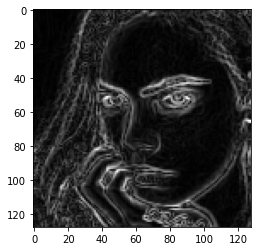

In [ ]:
sample = next(train_generator_1)
plt.imshow(sample[0][2], cmap='gray')

In [ ]:
model = models.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (224,224,1)))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(256, (3,3), activation = 'relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation = 'relu'))
model.add(tf.keras.layers.Dense(9, activation = 'softmax'))

In [ ]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['categorical_accuracy'])

In [ ]:
model_checkpoint_callback2 = tf.keras.callbacks.ModelCheckpoint(
               filepath = 'CNN_2_edges.h5', 
               monitor = 'val_categorical_accuracy', 
               save_best_only = True,)

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_categorical_accuracy",
                min_delta=0.01,
                patience=5,
                verbose=1,
                mode="max",
                baseline=None,
                restore_best_weights=False,
                start_from_epoch=0,
)

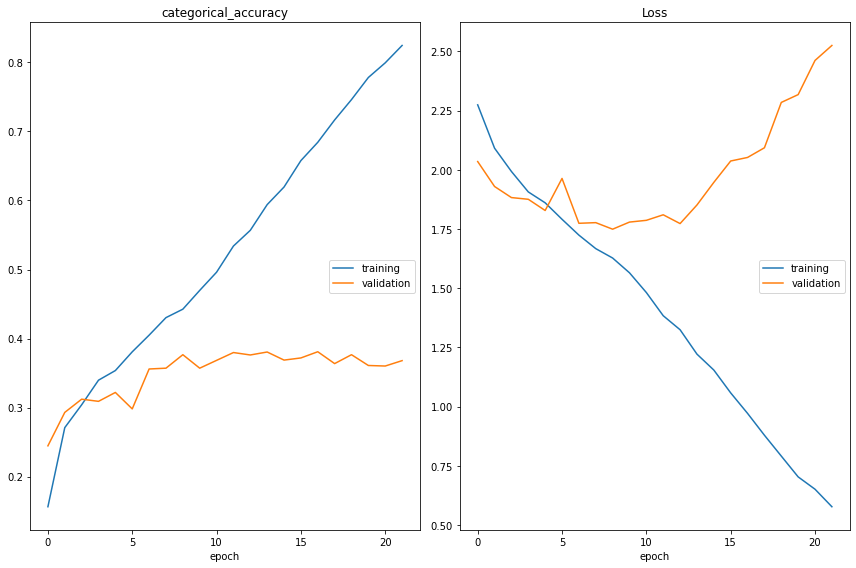

categorical_accuracy
	training         	 (min:    0.156, max:    0.825, cur:    0.825)
	validation       	 (min:    0.245, max:    0.381, cur:    0.368)
Loss
	training         	 (min:    0.577, max:    2.274, cur:    0.577)
	validation       	 (min:    1.749, max:    2.525, cur:    2.525)
80/80 [==============================] - 242s 3s/step - loss: 0.5775 - categorical_accuracy: 0.8246 - val_loss: 2.5249 - val_categorical_accuracy: 0.3680
Epoch 23/25
54/80 [===================>..........] - ETA: 1:15 - loss: 0.5131 - categorical_accuracy: 0.8454

KeyboardInterrupt: 

In [ ]:
%%time
history = model.fit( train_generator_1,
                      steps_per_epoch=600,
                      epochs = 100,
                      validation_data = test_generator_1,
                      validation_steps = 20,
                      callbacks = [PlotLossesCallback(), 
                                   model_checkpoint_callback2,
                                   early_stopping_callback],
                      class_weight=class_weight,
                      workers=8)

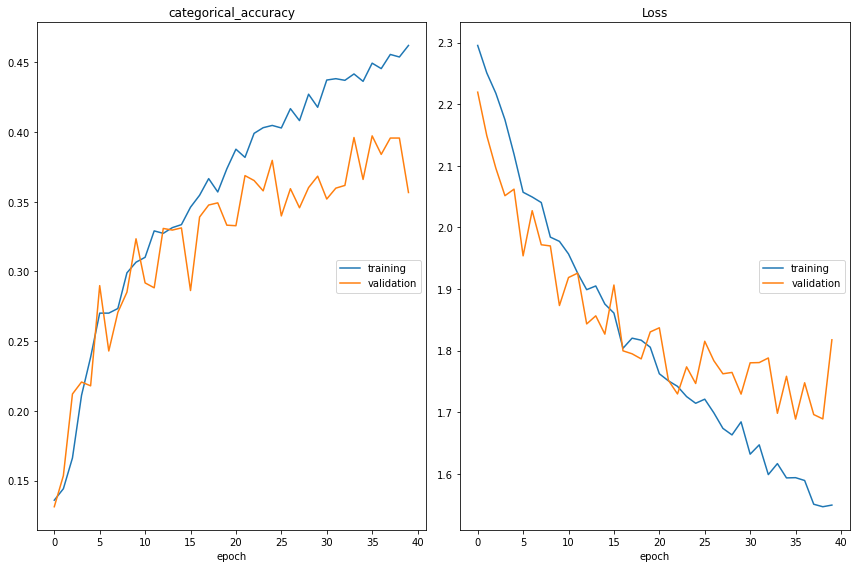

categorical_accuracy
	training         	 (min:    0.136, max:    0.462, cur:    0.462)
	validation       	 (min:    0.131, max:    0.397, cur:    0.357)
Loss
	training         	 (min:    1.546, max:    2.295, cur:    1.549)
	validation       	 (min:    1.689, max:    2.219, cur:    1.817)
40/40 [==============================] - 148s 4s/step - loss: 1.5491 - categorical_accuracy: 0.4621 - val_loss: 1.8174 - val_categorical_accuracy: 0.3566
Epoch 41/100
16/40 [===========>..................] - ETA: 1:05 - loss: 1.5161 - categorical_accuracy: 0.4688

KeyboardInterrupt: 

In [ ]:
%%time
history = model.fit( train_generator_1,
                      steps_per_epoch=80,
                      epochs = 25,
                      validation_data = test_generator_1,
                      validation_steps = 20,
                      callbacks = [PlotLossesCallback(), 
                                   model_checkpoint_callback],
                      class_weight=class_weight,
                      workers=8)

### The second variant of model

In [ ]:
model1 = tf.keras.Sequential()

model1.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', 
                                 activation='relu', input_shape = (128,128,1))) 
model1.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', 
                                 activation='relu')) 
model1.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model1.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', 
                                 activation='relu'))
model1.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', 
                                 activation='relu'))
model1.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model1.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', 
                                 activation='relu'))
model1.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', 
                                 activation='relu'))
model1.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model1.add(tf.keras.layers.Flatten())
model1.add(tf.keras.layers.Dense(256, activation='relu'))
model1.add(tf.keras.layers.Dropout(0.1))
model1.add(tf.keras.layers.Dense(9, activation='softmax'))


In [ ]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                  

In [ ]:
model1.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['categorical_accuracy'])

In [ ]:
model_checkpoint_callback2 = tf.keras.callbacks.ModelCheckpoint(
               filepath = 'model_main2_preprocess.h5', 
               monitor = 'val_categorical_accuracy', 
               save_best_only = True,)

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_categorical_accuracy",
                min_delta=0.01,
                patience=5,
                verbose=1,
                mode="max",
                baseline=None,
                restore_best_weights=False,
                start_from_epoch=0,
)

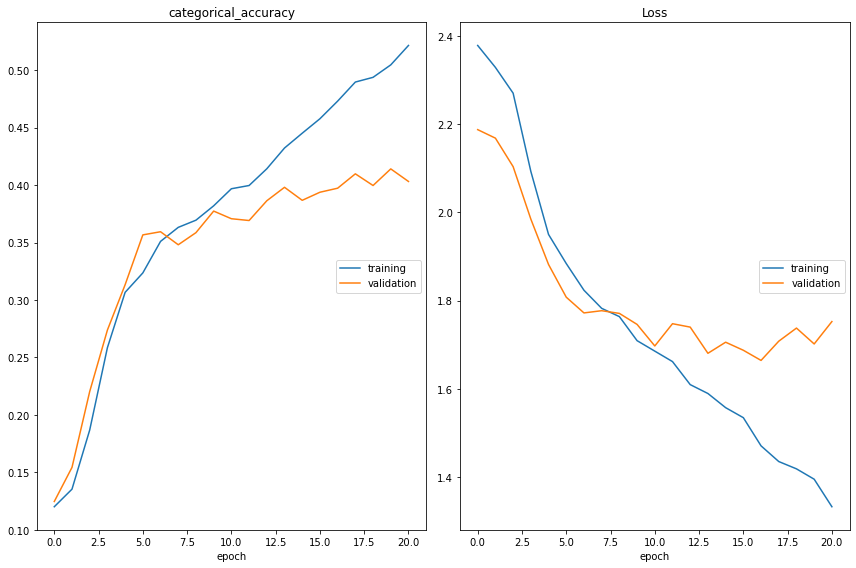

categorical_accuracy
	training         	 (min:    0.120, max:    0.521, cur:    0.521)
	validation       	 (min:    0.125, max:    0.414, cur:    0.403)
Loss
	training         	 (min:    1.333, max:    2.378, cur:    1.333)
	validation       	 (min:    1.664, max:    2.187, cur:    1.752)
80/80 [==============================] - 778s 10s/step - loss: 1.3327 - categorical_accuracy: 0.5215 - val_loss: 1.7524 - val_categorical_accuracy: 0.4031
Epoch 22/40
12/80 [===>..........................] - ETA: 10:05 - loss: 1.2630 - categorical_accuracy: 0.5423

KeyboardInterrupt: 

In [ ]:
%%time
history = model1.fit( train_generator_1,
                      steps_per_epoch=600,
                      epochs = 100,
                      validation_data = test_generator_1,
                      validation_steps = 20,
                      callbacks = [PlotLossesCallback(), 
                                   model_checkpoint_callback2,
                                   early_stopping_callback],
                      class_weight=class_weight,
                      workers = 8)

### The second model with regularization

In [ ]:
model02 = tf.keras.Sequential()

model02.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', 
                                 activation='relu', input_shape = (224,224,1))) 
model02.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', 
                                 activation='relu')) 
model02.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model02.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', 
                                 activation='relu'))
model02.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', 
                                 activation='relu'))
model02.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model02.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', 
                                 activation='relu'))
model02.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', 
                                 activation='relu'))
model02.add(tf.keras.layers.MaxPooling2D(pool_size=2))

model02.add(tf.keras.layers.Flatten())
model02.add(tf.keras.layers.Dense(256, kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4),
                                bias_regularizer=regularizers.L2(1e-4),
                                activity_regularizer=regularizers.L2(1e-4),
                                activation='relu'))
model02.add(tf.keras.layers.Dropout(0.1))
model02.add(tf.keras.layers.Dense(9, activation='softmax'))


In [ ]:
model02.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['categorical_accuracy'])

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
               filepath = 'model_main02_reg.h5', 
               monitor = 'val_categorical_accuracy', 
               save_best_only = True,)

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_categorical_accuracy",
                min_delta=0.01,
                patience=5,
                verbose=1,
                mode="max",
                baseline=None,
                restore_best_weights=False,
                start_from_epoch=0,
)

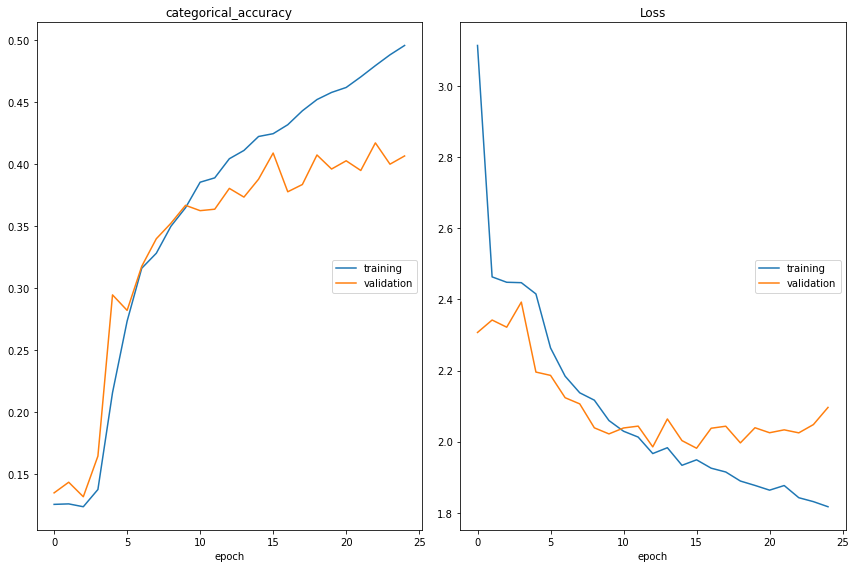

categorical_accuracy
	training         	 (min:    0.124, max:    0.496, cur:    0.496)
	validation       	 (min:    0.132, max:    0.417, cur:    0.407)
Loss
	training         	 (min:    1.817, max:    3.115, cur:    1.817)
	validation       	 (min:    1.981, max:    2.393, cur:    2.096)
80/80 [==============================] - 812s 10s/step - loss: 1.8169 - categorical_accuracy: 0.4958 - val_loss: 2.0963 - val_categorical_accuracy: 0.4066
Wall time: 5h 10min 8s


In [ ]:
%%time
history = model02.fit( train_generator_1,
                      steps_per_epoch=600,
                      epochs = 100,
                       validation_data = test_generator_1,
                      validation_steps = 20,
                      callbacks = [PlotLossesCallback(), 
                                   model_checkpoint_callback,
                                   early_stopping_callback],
                      class_weight=class_weight)

### Vizualization

In [ ]:
def show_pred(images, labels, predicted_labels=None):
    plt.figure(figsize=(15,15))
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = image.load_img(images[i])
        plt.imshow(img)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {labels[i]}. Pred: {predicted_labels[i]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {labels[i]}")

157/157 [==============================] - 84s 535ms/step


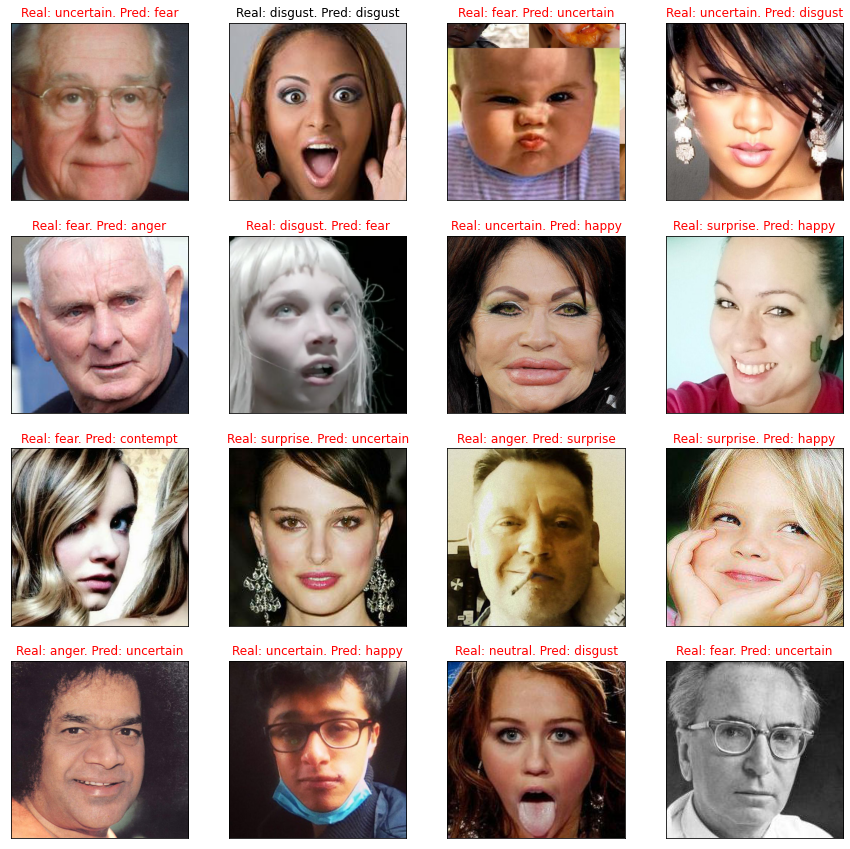

In [ ]:
predicted_labels = model.predict(test_generator_1)
idxs = np.random.choice(np.arange(len(test_generator_1.filenames)), 16, replace=False)
fnames = []
labels = []
preds = []
for i in idxs:
  fnames.append('/content/drive/MyDrive/course_work_nn/train/' + test_generator_1.filenames[i])
  labels.append(list(set(df['emotion']))[test_generator_1.labels[i]])
  preds.append(list(set(df['emotion']))[np.argmax(predicted_labels[i])])
show_pred(fnames, labels, preds)

### File for Kaggle

In [ ]:
!cd /content/drive/MyDrive/course_work_nn/test_kaggle && unzip -q test_kaggle.zip

In [ ]:
# shutil.rmtree('/content/drive/MyDrive/course_work_nn/test_kaggle')

In [ ]:
datagen = ImageDataGenerator(rescale = 1/255.)

In [ ]:
test_generator = datagen.flow_from_directory(directory = 'test_kaggle/test_kaggle/',
                                       target_size=(128,128),
                                       class_mode='categorical',
                                       classes=['.'],
                                       shuffle = False,
                                       batch_size=1)

Found 5000 images belonging to 1 classes.


In [ ]:
emotions = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise', 'uncertain']

In [ ]:
model01 = tf.keras.models.load_model('/content/drive/MyDrive/CNN1_.h5')

In [ ]:
results = model01.evaluate(x_test, y_test, batch_size=128)
print('test loss, test acc:', results)

In [ ]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
pred=model01.predict(test_generator,steps=STEP_SIZE_TEST,verbose=1)

predictions = []
for i in pred:
    predictions.append(emotions[np.argmax(i)])

filenames = []
for i in test_generator.filenames:
    filn = i.replace(".\\",'')
    filenames.append(filn)

results=pd.DataFrame({"image_path":filenames,
                      "emotion":predictions})

In [ ]:
results.to_csv('CNN_reg.csv', index=False)